### Prepare data

In [ ]:
import pandas as pd
import numpy as np
import random

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint


random.seed(42)
np.random.seed(42)
pl.seed_everything(42, workers=True)

# Dataset must be downloaded first: https://doi.org/10.5281/zenodo.15226382
uwb_data_nxp = pd.read_pickle('<dataset_path>/data.pkl')

los = uwb_data_nxp[uwb_data_nxp['l'] == 1]
nlos = uwb_data_nxp[uwb_data_nxp['l'] == 0]

desired_nlos_percentage = 0.7
los = los.sample(int((1 - desired_nlos_percentage) * len(nlos) / desired_nlos_percentage), random_state=42)

uwb_data_nxp = pd.concat([los, nlos])

uwb_data_nxp.head()

fp_idx = 8

prior_fp = 5
after_fp = 128

cir_data = uwb_data_nxp['CIR'].values

cir_data = np.array([np.array([x.real, x.imag]).T for x in cir_data])
cir_data = cir_data[:, fp_idx - prior_fp: fp_idx + after_fp]

errors = uwb_data_nxp['e'].values
labels = uwb_data_nxp['l'].values

X = torch.tensor(cir_data, dtype=torch.float32)
y = torch.tensor(errors, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

class UWBDataModule(pl.LightningDataModule):
    def __init__(self, X, y, labels, batch_size=200):
        super().__init__()
        self.X = X
        self.y = y
        self.labels = labels
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        dataset = data.TensorDataset(self.X, self.y, self.labels)
        train_size = int(0.7 * len(dataset))
        val_size = int(0.2 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        
        generator = torch.Generator()
        generator.manual_seed(42)

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=24, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=24, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=24, pin_memory=True)

Seed set to 42


### Train

In [21]:
from model import ARemNet

In [15]:
model = ARemNet(k=162, input_channels=2, low_level_features=64, num_rrms=5, num_heads=4, attention_unit=True, num_classes=1, lr=1e-3)

data_module = UWBDataModule(X, y, labels, batch_size=256)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best_model",
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=100, 
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        LearningRateMonitor(logging_interval='epoch'),
        checkpoint_callback
    ],
    accelerator="gpu" if torch.cuda.is_available() else "cpu", 
    devices=3,
)

# trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


#### Load pre-trained models

In [8]:
remnet_path = 'pretrained/remnet.ckpt'
aremnet_path = 'pretrained/aremnet.ckpt'

model_no_att = ARemNet.load_from_checkpoint(remnet_path)
model_att = ARemNet.load_from_checkpoint(aremnet_path)

print(model_no_att)
print(model_att)

ARemNet(
  (conv1d): Conv1d(2, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (rrms): ModuleList(
    (0-4): 5 x ResidualReductionModule(
      (residual_unit): ResidualUnit(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (se_block): SEBlock(
          (squeeze): AdaptiveAvgPool1d(output_size=1)
          (fc1): Linear(in_features=64, out_features=8, bias=True)
          (fc2): Linear(in_features=8, out_features=64, bias=True)
        )
      )
      (reduction_block): ReductionBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(2,))
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=320, out_features=1, bias=True)
  (criterion): SmoothL1Loss()
)
ARemNet(
  (conv1d): Conv1d(2, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (rrms): ModuleList(
    (0-1): 2 x ResidualReductionModule(
      (pos_encoding): LearnablePosi

In [ ]:
print(f"Trainable Parameters (No Attention): {sum(p.numel() for p in model_no_att.parameters() if p.requires_grad)}")
print(f"Trainable Parameters (With Attention): {sum(p.numel() for p in model_att.parameters() if p.requires_grad)}")

Trainable Parameters (No Attention): 151337
Trainable Parameters (With Attention): 200425


In [13]:
model_no_att.eval()
model_att.eval()
model_no_att.freeze()
model_att.freeze()
model_no_att.to('cuda')
model_att.to('cuda')

print("Evaluation")

Evaluation


### Evaluate

#### Ablation study and error analysis

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    all_preds = []
    all_targets = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y_true, l = batch
            x = x.to(device)
            y_true = y_true.to(device).float()
            l = l.to(device).float()

            y_pred = model(x).squeeze()
            all_preds.append(y_pred)
            all_targets.append(y_true)
            all_labels.append(l)

    y_preds = torch.cat(all_preds).cpu().numpy()
    y_true = torch.cat(all_targets).cpu().numpy()
    labels = torch.cat(all_labels).cpu().numpy()

    residuals = y_true - y_preds
    abs_errors = np.abs(y_true)
    abs_residuals = np.abs(residuals)

    def compute_stats(mask):
        return {
            'mean_before': np.mean(y_true[mask]),
            'std_before': np.std(y_true[mask]),
            'mae_before': np.mean(abs_errors[mask]),
            'mean_after': np.mean(residuals[mask]),
            'std_after': np.std(residuals[mask]),
            'mae_after': np.mean(abs_residuals[mask]),
        }

    overall = compute_stats(np.ones_like(labels, dtype=bool))
    los = compute_stats(labels == 1)
    nlos = compute_stats(labels == 0)

    return {
        'overall': overall,
        'LOS': los,
        'NLOS': nlos,
        'predictions': y_preds,
        'true_errors': y_true,
        'residual_errors': residuals,
        'labels': labels
    }

def print_results(results):
    for k, v in results.items():
        if k in ['overall', 'LOS', 'NLOS']:
            print(f"{k} stats:")
            for metric, val in v.items():
                print(f"  {metric}: {val:.2f} cm")

data_module.setup(stage='test')

test_loader = data_module.test_dataloader()

results_no_att = evaluate_model(model_no_att, test_loader)
results_att = evaluate_model(model_att, test_loader)

print("Results for model without attention:")
print_results(results_no_att)
print("Results for model with attention:")
print_results(results_att)

Results for model without attention:
overall stats:
  mean_before: 13.96 cm
  std_before: 19.38 cm
  mae_before: 15.25 cm
  mean_after: 0.45 cm
  std_after: 9.53 cm
  mae_after: 5.12 cm
LOS stats:
  mean_before: 3.72 cm
  std_before: 7.84 cm
  mae_before: 5.64 cm
  mean_after: -0.74 cm
  std_after: 4.12 cm
  mae_after: 2.42 cm
NLOS stats:
  mean_before: 18.34 cm
  std_before: 21.12 cm
  mae_before: 19.35 cm
  mean_after: 0.96 cm
  std_after: 11.02 cm
  mae_after: 6.28 cm
Results for model with attention:
overall stats:
  mean_before: 13.96 cm
  std_before: 19.38 cm
  mae_before: 15.25 cm
  mean_after: 0.51 cm
  std_after: 8.50 cm
  mae_after: 4.54 cm
LOS stats:
  mean_before: 3.72 cm
  std_before: 7.84 cm
  mae_before: 5.64 cm
  mean_after: -0.22 cm
  std_after: 3.77 cm
  mae_after: 2.19 cm
NLOS stats:
  mean_before: 18.34 cm
  std_before: 21.12 cm
  mae_before: 19.35 cm
  mean_after: 0.82 cm
  std_after: 9.83 cm
  mae_after: 5.55 cm


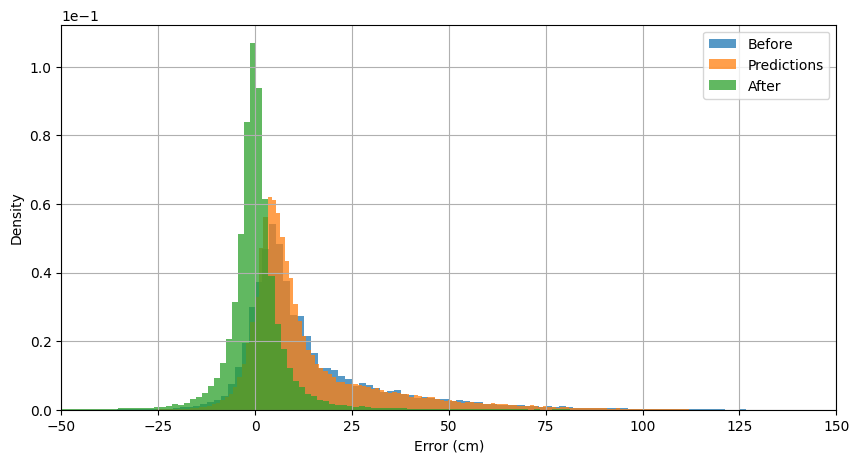

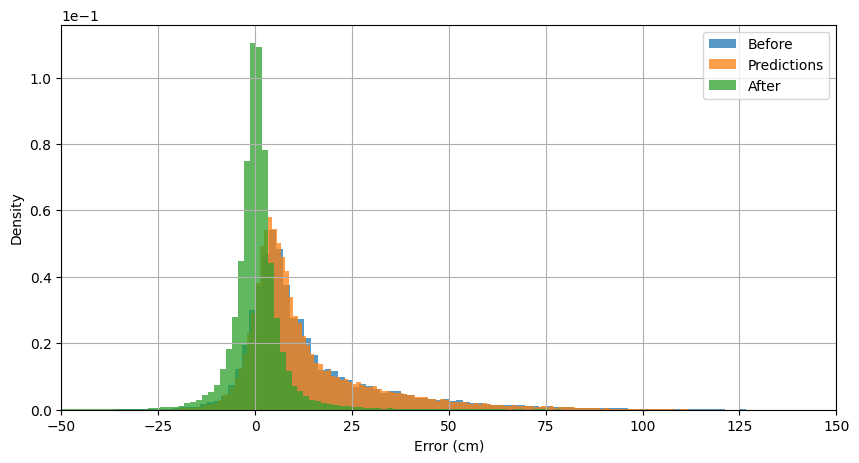

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_distribution(errors_before, errors_after, predictions, labels):
    plt.figure(figsize=(10, 5))
    sns.histplot(errors_before, bins=150, label='Before', stat='density', alpha=0.75, edgecolor=None)
    sns.histplot(predictions, bins=150,  label='Predictions', stat='density', alpha=0.75, edgecolor=None)
    sns.histplot(errors_after, bins=200,   label='After', stat='density', alpha=0.75, edgecolor=None)
    plt.xlabel('Error (cm)')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.xlim(-50, 150)
    plt.grid()
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    plt.savefig('error_distribution_mitigated.pdf', bbox_inches='tight')


plot_error_distribution(
    results_no_att['true_errors'],
    results_no_att['residual_errors'],
    results_no_att['predictions'],
    results_no_att['labels']
)
plot_error_distribution(
    results_att['true_errors'],
    results_att['residual_errors'],
    results_att['predictions'],
    results_att['labels']
)

#### Inference time and FLOPs

In [18]:
from fvcore.nn import FlopCountAnalysis, parameter_count_table

input = torch.randn(1, 133, 2).cuda()
model.eval().cuda()

flops = FlopCountAnalysis(model, input)
print(flops.total() / 1e6, "MFLOPs")
print(parameter_count_table(model))

Unsupported operator aten::add encountered 9 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::unflatten encountered 2 time(s)
Unsupported operator aten::mul encountered 15 time(s)
Unsupported operator aten::softmax encountered 2 time(s)
Unsupported operator aten::adaptive_avg_pool1d encountered 5 time(s)
Unsupported operator aten::sigmoid encountered 5 time(s)
Unsupported operator aten::add_ encountered 5 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
criterion, rrms.0.self_attention.attention.out_proj, rrms.1.self_attention.attention.out_proj


11.695808 MFLOPs
| name                      | #elements or shape   |
|:--------------------------|:---------------------|
| model                     | 0.2M                 |
|  conv1d                   |  1.2K                |
|   conv1d.weight           |   (64, 2, 9)         |
|   conv1d.bias             |   (64,)              |
|  rrms                     |  0.2M                |
|   rrms.0                  |   57.1K              |
|    rrms.0.pos_encoding    |    10.4K             |
|    rrms.0.self_attention  |    16.8K             |
|    rrms.0.residual_unit   |    13.4K             |
|    rrms.0.reduction_block |    16.5K             |
|   rrms.1                  |   51.9K              |
|    rrms.1.pos_encoding    |    5.2K              |
|    rrms.1.self_attention  |    16.8K             |
|    rrms.1.residual_unit   |    13.4K             |
|    rrms.1.reduction_block |    16.5K             |
|   rrms.2                  |   30.0K              |
|    rrms.2.residual_unit   |

In [ ]:
import time

model.eval().cuda()
dummy_input = torch.randn(1, 133, 2).cuda()

for _ in range(100):
    _ = model(dummy_input)

times = []
with torch.no_grad():
    for _ in range(1000):
        start = time.time()
        _ = model(dummy_input)
        torch.cuda.synchronize()
        end = time.time()
        times.append((end - start) * 1000)  # ms

print(f"Inference Time: {np.mean(times):.3f} ± {np.std(times):.3f} ms")

Inference Time: 2.926 ± 0.032 ms
